In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Import data

* https://fred.stlouisfed.org

<AxesSubplot:xlabel='DATE'>

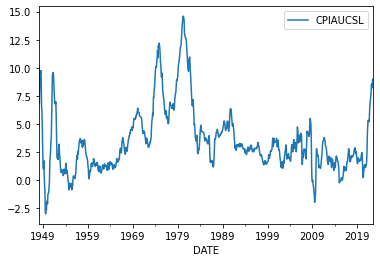

In [2]:
inflation=pd.read_csv('data/inflation.csv',index_col='DATE',parse_dates=True).pct_change(12).dropna()*100
inflation.plot()

In [3]:
inflation.tail()

,CPIAUCSL
DATE,
2022-04-01,8.224139
2022-05-01,8.516413
2022-06-01,8.995221
2022-07-01,8.482130
2022-08-01,8.249235


<AxesSubplot:xlabel='DATE'>

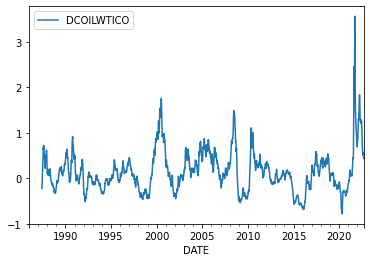

In [4]:
oil=pd.read_csv('data/oil.csv',index_col='DATE',parse_dates=True)
oil['DCOILWTICO']=pd.to_numeric(oil['DCOILWTICO'], errors='coerce')
oil=oil.pct_change(360).rolling(12).mean()
oil.plot()

<AxesSubplot:xlabel='DATE'>

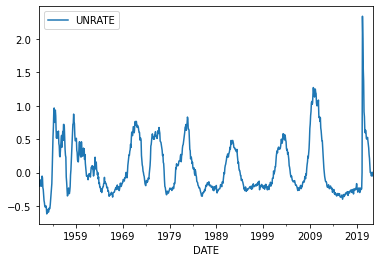

In [5]:
unemployment=pd.read_csv('data/unemployment.csv',index_col='DATE',parse_dates=True)
unemployment['UNRATE']=pd.to_numeric(unemployment['UNRATE'], errors='coerce').dropna()
unemployment=unemployment.pct_change(36).dropna()
unemployment.plot()

<AxesSubplot:xlabel='DATE'>

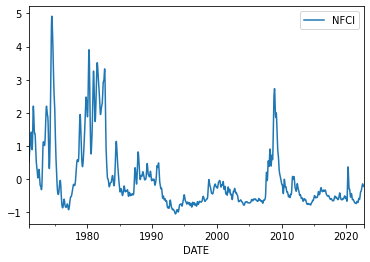

In [6]:
fincond=pd.read_csv('data/fincond.csv',index_col='DATE',parse_dates=True)
fincond['NFCI']=pd.to_numeric(fincond['NFCI'], errors='coerce').dropna()

fincond.plot()

<AxesSubplot:xlabel='DATE'>

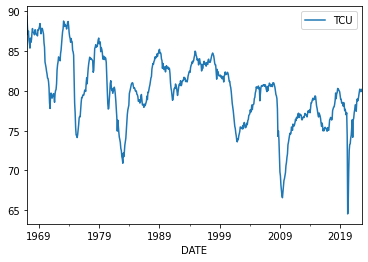

In [7]:
capacity=pd.read_csv('data/capacity.csv',index_col='DATE',parse_dates=True)
capacity['TCU']=pd.to_numeric(capacity['TCU'], errors='coerce').dropna()

capacity.plot()

<AxesSubplot:xlabel='DATE'>

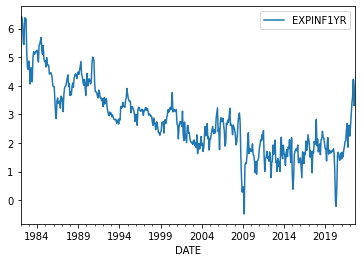

In [8]:
expected=pd.read_csv('data/expected.csv',index_col='DATE',parse_dates=True)
expected['EXPINF1YR']=pd.to_numeric(expected['EXPINF1YR'], errors='coerce').dropna()

expected.plot()

In [9]:
expected.tail()

,EXPINF1YR
DATE,
2022-05-01,3.634658
2022-06-01,4.226713
2022-07-01,3.309278
2022-08-01,3.377132
2022-09-01,4.179574


#  Data Cleaning

In [10]:
a=[]
for x in [unemployment,fincond,expected,capacity,oil]: a.append(x.resample('MS').ffill())

In [11]:
df=pd.concat(a,axis=1).ffill()
df.tail()

,UNRATE,NFCI,EXPINF1YR,TCU,DCOILWTICO
DATE,,,,,
2022-05-01,0.000000,-0.33287,3.634658,80.0369,1.276872
2022-06-01,0.000000,-0.24678,4.226713,79.9055,1.261229
2022-07-01,-0.054054,-0.14642,3.309278,80.2024,0.966823
2022-08-01,0.000000,-0.17502,3.377132,79.9605,0.581947
2022-09-01,0.000000,-0.21706,4.179574,79.9605,0.541335


In [12]:
forecast_windows=12 ## MONTHS AHEAD FOR PREDICTION
df['12ma Inflation']=inflation.shift(-forecast_windows).resample('MS').ffill()

In [13]:
df=df.dropna(thresh=5,axis=0)
df

,UNRATE,NFCI,EXPINF1YR,TCU,DCOILWTICO,12ma Inflation
DATE,,,,,,
1982-01-01,0.457627,2.04854,6.394507,74.9452,NaN,3.707627
1982-02-01,0.508475,1.95657,6.432108,76.3157,NaN,3.484688
1982-03-01,0.551724,2.08113,6.387732,75.6444,NaN,3.590285
1982-04-01,0.603448,2.19132,6.140628,74.8135,NaN,4.000000
1982-05-01,0.678571,2.29127,5.488167,74.1783,NaN,3.441084
...,...,...,...,...,...,...
2022-05-01,0.000000,-0.33287,3.634658,80.0369,1.276872,NaN
2022-06-01,0.000000,-0.24678,4.226713,79.9055,1.261229,NaN
2022-07-01,-0.054054,-0.14642,3.309278,80.2024,0.966823,NaN


In [14]:
split_date='2011-01-01'
df_train=df[df.index < split_date]
df_test=df[df.index > split_date]
split_date=df_train.index[-1]
split_date

Timestamp('2010-12-01 00:00:00', freq='MS')

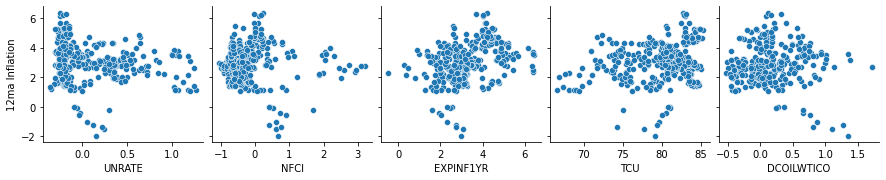

In [15]:
sns.pairplot(data=df_train,x_vars=df.columns[:-1],y_vars=df.columns[-1])

# Model Fitting

In [16]:
from xgboost import  XGBRegressor

In [17]:
import itertools
parameters={'random_state': [100],'max_depth': [3,5,6,8],'n_estimators': [100,200,300,500],'eta':[0.1,0.2,0.3]}
parameters_=list((dict(zip(parameters, x)) for x in itertools.product(*parameters.values())))

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import explained_variance_score


acc=[]
accuracy=[]
for param in parameters_:
    tscv = TimeSeriesSplit(n_splits=3)
    model = XGBRegressor(**param)
    for train_index, test_index in tscv.split(df_train):
        X_train, X_test = df_train.iloc[train_index,:-1], df_train.iloc[test_index,:-1]
        y_train, y_test = df_train.iloc[train_index,-1], df_train.iloc[test_index,-1]
        model.fit(X_train, y_train)
        
        y_binary = model.predict(X_test)

        # scoring
        acc.append(explained_variance_score(y_test,y_binary))
    accuracy.append(np.mean(acc))

best_param = parameters_[np.argmax(accuracy)]
best_param

{'random_state': 100, 'max_depth': 8, 'n_estimators': 500, 'eta': 0.2}

# Model Evaluation

In [19]:
X,y=df_test.iloc[:,:-1],df_test.iloc[:,-1] 
predicted=[]
roll=12
for i in range(roll,len(df_test)-forecast_windows):
    model = XGBRegressor(**best_param)

    X_fit = X.iloc[i-roll:i]
    y_fit = y.iloc[i-roll:i]

    model = model.fit(X_fit, y_fit)

    X_predict = X.iloc[i:i+ 1]
    y_pred = model.predict(X_predict)
    predicted.append(y_pred)

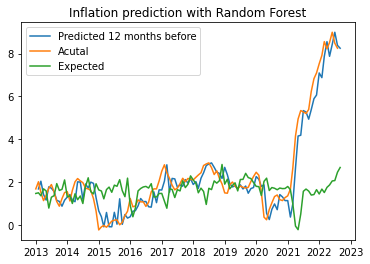

In [31]:
predicted_df=pd.DataFrame(predicted,index=df_test.iloc[forecast_windows+roll:].index)
plt.plot(predicted_df,label='Predicted 12 months before')
plt.plot(inflation['2013':],label='Acutal')
plt.plot(expected['2012':].shift(12),label='Expected')
plt.title('Inflation prediction with Random Forest')
plt.legend()
plt.show()

In [21]:
df['CORESTICKM159SFRBATL']=inflation

In [22]:
y_actual=df.loc[df_test.index]['CORESTICKM159SFRBATL'].iloc[roll+forecast_windows:].ffill()

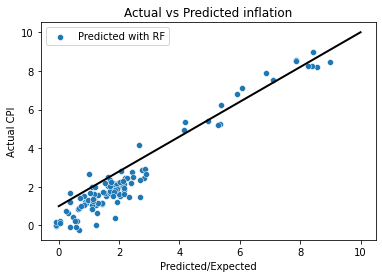

In [23]:
#sns.scatterplot(x=expected.loc[df_test.index].iloc[:,0],y=df_test['CORESTICKM159SFRBATL'],label='Market expectation')
sns.scatterplot(x=predicted_df.iloc[:,0],y=y_actual,label='Predicted with RF')
plt.plot([0, 10], [1, 10], linewidth=2,color='black')
plt.xlabel('Predicted/Expected')
plt.ylabel('Actual CPI')
plt.legend()
plt.title('Actual vs Predicted inflation')
plt.show()

In [24]:
print('Explained Variance: ', explained_variance_score(y_actual,predicted_df))
from sklearn.metrics import mean_absolute_error
print('Mean Abs Error: ', mean_absolute_error(y_actual,predicted_df))
from sklearn.metrics import max_error
print('Max Error: ', max_error(y_actual,predicted_df))

Explained Variance:  0.942338559185199
Mean Abs Error:  0.39984086803456975
Max Error:  1.6633223148419587


In [25]:
model = XGBRegressor(**best_param)

X_fit = df.iloc[-forecast_windows-roll:-forecast_windows,:-2]
y_fit = df.iloc[-forecast_windows-roll:-forecast_windows,-2].ffill()

model = model.fit(X_fit, y_fit)

y_pred = model.predict(df.iloc[-forecast_windows:,:-2])

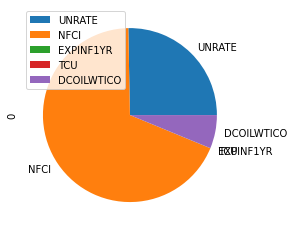

In [26]:
pd.DataFrame(model.feature_importances_,X.columns).plot.pie(subplots=True)
plt.show()

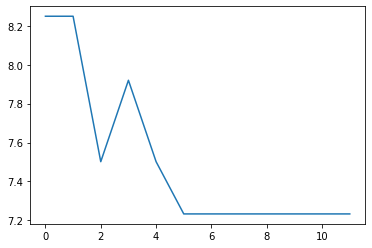

In [27]:
plt.plot(pd.DataFrame(y_pred))
plt.show()

In [28]:
print('Expected inflation in september 2023: ', "{:.2%}".format(y_pred[-1]/100))

Expected inflation in september 2023:  7.23%
